# Run and process the prior monte carlo and pick a "truth" realization

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))

### Decide what pars are uncertain in the truth

We need to decide what our truth looks like - should the pilot points or the grid-scale pars be the source of spatial variability? or both?

In [3]:
par = pst.parameter_data
# grid pars
#should_fix = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
# pp pars
#should_fix = par.loc[par.pargp.apply(lambda x: "pp" in x),"parnme"]
#pst.npar - should_fix.shape[0]

In [4]:
pe = pyemu.ParameterEnsemble.from_binary(pst=pst,filename=os.path.join(t_d,"prior.jcb"))
#pe.loc[:,should_fix] = 1.0
pe.to_csv(os.path.join(t_d,"sweep_in.csv"))

new binary format detected...


### run the prior ensemble in parallel locally

In [5]:
m_d = "master_prior_sweep"
pyemu.os_utils.start_slaves(t_d,"pestpp-swp","freyberg.pst",num_slaves=20,slave_root=".",master_dir=m_d)

### Load the output ensemble and plot a few things



In [6]:
obs_df = pd.read_csv(os.path.join(m_d,"sweep_out.csv"),index_col=0)
obs_df.shape

(200, 4465)

drop any failed runs

In [7]:
obs_df = obs_df.loc[obs_df.failed_flag==0,:]
obs_df.shape

(200, 4465)

In [8]:
fnames = pst.pestpp_options["forecasts"].split(',')
fnames

['fa_hw_19791230',
 'fa_hw_19801229',
 'fa_tw_19791230',
 'fa_tw_19801229',
 'hds_00_013_002_000',
 'hds_00_013_002_001',
 'part_time',
 'part_status']

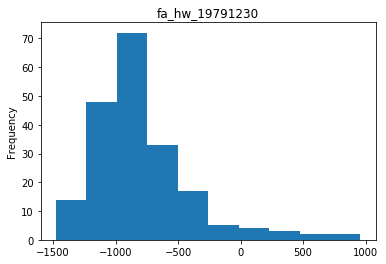

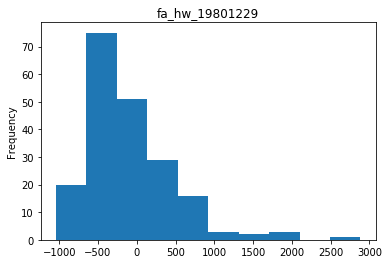

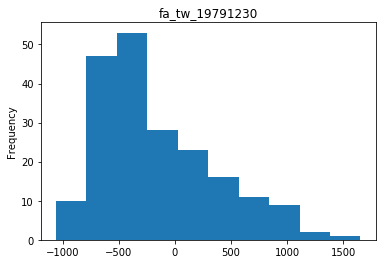

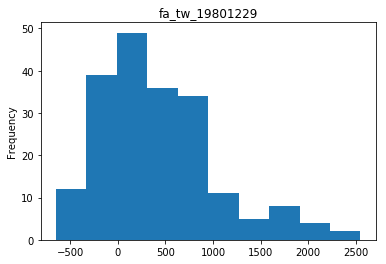

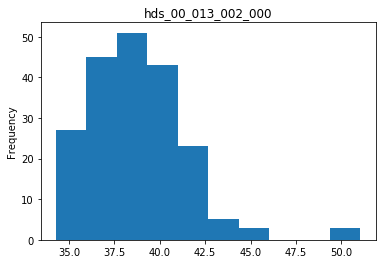

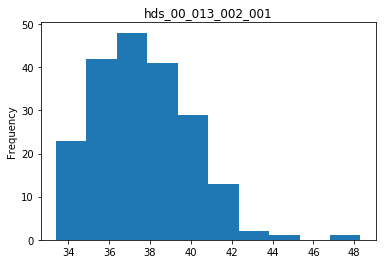

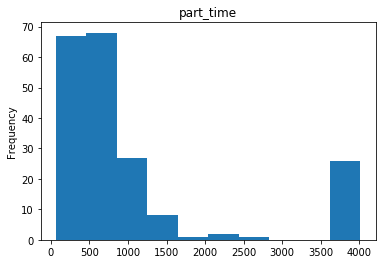

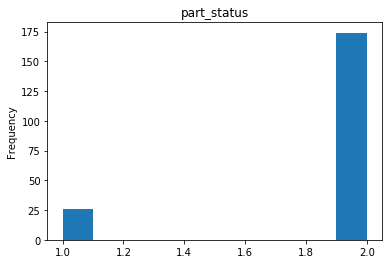

In [9]:
for forecast in fnames:
    ax = obs_df.loc[:,forecast].plot(kind="hist")
    ax.set_title(forecast)
    plt.show()

We see that under scenario conditions, many more realizations for the flow to the aquifer in the headwaters are postive (as expected).  Lets difference these two:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x181b645390>,
      dtype=object)

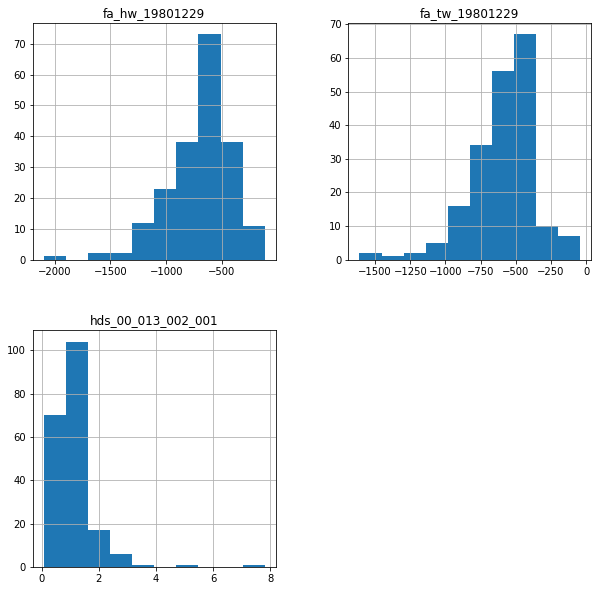

In [10]:
sfnames = [f for f in fnames if "1980" in f or "_001" in f]
hfnames = [f for f in fnames if "1979" in f or "_000" in f]
diff = obs_df.loc[:,hfnames].values - obs_df.loc[:,sfnames].values
diff = pd.DataFrame(diff,columns=sfnames)
diff.hist(figsize=(10,10))

We now see that the most extreme scenario yields a large decrease in flow from the aquifer to the headwaters (the most negative value)

### setting the "truth"

We just need to replace the observed values (`obsval`) in the control file with the outputs for one of the realizations on `obs_df`.  In this way, we now have the nonzero values for history matching, but also the ``truth`` values for comparing how we are doing with other unobserved quantities.  Im going to pick a realization that yields an "average" variability of the observed gw levels:

In [11]:
# choose the realization with a low historic gw to sw headwater flux
hist_swgw = obs_df.loc[:,"fa_hw_19791230"].sort_values()
idx = hist_swgw.index[10]
idx

26

In [12]:
obs_df.loc[idx,pst.nnz_obs_names]

fo_39_19791230        11200.000000
hds_00_002_009_000       35.298595
hds_00_002_015_000       34.651405
hds_00_003_008_000       35.381458
hds_00_009_001_000       36.549999
hds_00_013_010_000       34.945221
hds_00_015_016_000       34.754948
hds_00_021_010_000       34.856949
hds_00_022_015_000       34.468357
hds_00_024_004_000       35.140781
hds_00_026_006_000       34.859554
hds_00_029_015_000       34.306465
hds_00_033_007_000       33.894123
hds_00_034_010_000       33.719563
Name: 26, dtype: float64

Lets see how our selected truth does with the swgw forecasts:

In [13]:
obs_df.loc[idx,fnames]

fa_hw_19791230       -1265.704600
fa_hw_19801229        -555.443500
fa_tw_19791230        -257.454120
fa_tw_19801229         210.098000
hds_00_013_002_000      36.337082
hds_00_013_002_001      35.521656
part_time             4015.000000
part_status              1.000000
Name: 26, dtype: float64

In [14]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
obs = pst.observation_data
obs.loc[:,"obsval"] = obs_df.loc[idx,pst.obs_names]
obs.loc[obs.obgnme=="calhead","weight"] = 5.0
obs.loc[obs.obgnme=="calflux","weight"] = 0.035
obs.weight.value_counts()

0.000    4422
5.000      13
0.035       1
Name: weight, dtype: int64

Now, it is custom to add noise to the observed values...we will use the classic Gaussian noise...zero mean and standard deviation of 1 over the weight

In [15]:
# this should give the same standard normal draws each time
np.random.seed(seed=0)
snd = np.random.randn(pst.nnz_obs)
snd

array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
       -0.97727788,  0.95008842, -0.15135721, -0.10321885,  0.4105985 ,
        0.14404357,  1.45427351,  0.76103773,  0.12167502])

In [16]:
noise = snd * 1./obs.loc[pst.nnz_obs_names,"weight"]
noise

obsnme
fo_39_19791230        50.401496
hds_00_002_009_000     0.080031
hds_00_002_015_000     0.195748
hds_00_003_008_000     0.448179
hds_00_009_001_000     0.373512
hds_00_013_010_000    -0.195456
hds_00_015_016_000     0.190018
hds_00_021_010_000    -0.030271
hds_00_022_015_000    -0.020644
hds_00_024_004_000     0.082120
hds_00_026_006_000     0.028809
hds_00_029_015_000     0.290855
hds_00_033_007_000     0.152208
hds_00_034_010_000     0.024335
Name: weight, dtype: float64

Only run this block once!!!

In [17]:
pst.observation_data.loc[noise.index,"obsval"] += noise
pst.write(os.path.join(t_d,"freyberg.pst"))
pyemu.os_utils.run("pestpp-ies freyberg.pst",cwd=t_d)

In [18]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

472.59650318891005


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,11250.401496,11430.000000,-179.598504,0.035
hds_00_002_009_000,hds_00_002_009_000,calhead,35.378627,37.107498,-1.728871,5.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.847153,35.045185,-0.198032,5.000
hds_00_003_008_000,hds_00_003_008_000,calhead,35.829637,37.397289,-1.567652,5.000
hds_00_009_001_000,hds_00_009_001_000,calhead,36.923511,39.546417,-2.622906,5.000
hds_00_013_010_000,hds_00_013_010_000,calhead,34.749765,35.571774,-0.822008,5.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.944965,34.835716,0.109249,5.000
hds_00_021_010_000,hds_00_021_010_000,calhead,34.826677,35.386250,-0.559572,5.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.447713,34.577492,-0.129778,5.000


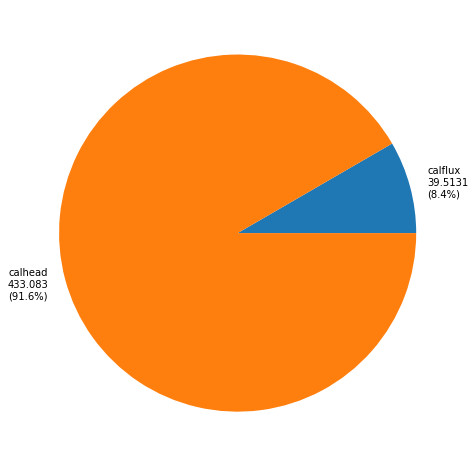

In [19]:
pst.phi_components
pst.plot(kind='phi_pie')

<Figure size 576x756 with 0 Axes>

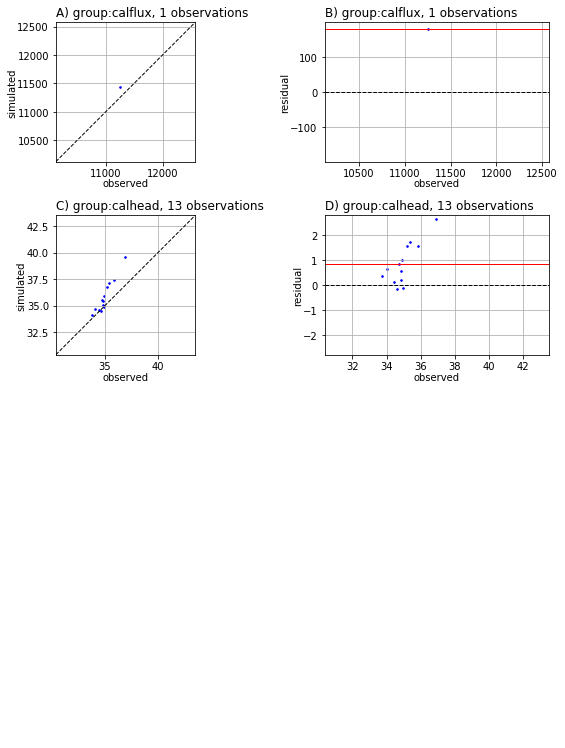

In [20]:
figs = pst.plot(kind="1to1")

Publication ready figs - oh snap!

Just to make sure we have everything working right, we should be able to load the truth parameters, run the model once and have a `phi` equivalent to the noise vector:

In [21]:
par_df = pd.read_csv(os.path.join(m_d,"sweep_in.csv"),index_col=0)
pst.parameter_data.loc[:,"parval1"] = par_df.loc[idx,pst.par_names]
pst.write(os.path.join(m_d,"test.pst"))
pyemu.os_utils.run("pestpp-ies.exe test.pst",cwd=m_d)
pst = pyemu.Pst(os.path.join(m_d,"test.pst"))
print(pst.phi)
pst.res.loc[pst.nnz_obs_names,:]

17.528847256189565


,name,group,measured,modelled,residual,weight
name,,,,,,
fo_39_19791230,fo_39_19791230,calflux,11250.401496,11200.000000,50.401496,0.035
hds_00_002_009_000,hds_00_002_009_000,calhead,35.378627,35.298595,0.080031,5.000
hds_00_002_015_000,hds_00_002_015_000,calhead,34.847153,34.651405,0.195748,5.000
hds_00_003_008_000,hds_00_003_008_000,calhead,35.829637,35.381458,0.448179,5.000
hds_00_009_001_000,hds_00_009_001_000,calhead,36.923511,36.549999,0.373512,5.000
hds_00_013_010_000,hds_00_013_010_000,calhead,34.749765,34.945221,-0.195456,5.000
hds_00_015_016_000,hds_00_015_016_000,calhead,34.944965,34.754948,0.190018,5.000
hds_00_021_010_000,hds_00_021_010_000,calhead,34.826677,34.856949,-0.030271,5.000
hds_00_022_015_000,hds_00_022_015_000,calhead,34.447713,34.468357,-0.020644,5.000


The residual should be exactly the noise values from above.Lets load the model (that was just run using the true pars) and check some things

In [22]:
m = flopy.modflow.Modflow.load("freyberg.nam",model_ws=m_d)

0.009521352 1.351456


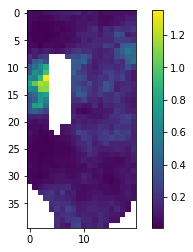

In [23]:
a = m.upw.vka[1].array
#a = m.rch.rech[0].array
a = np.ma.masked_where(m.bas6.ibound[0].array==0,a)
print(a.min(),a.max())
c = plt.imshow(a)
plt.colorbar(c)

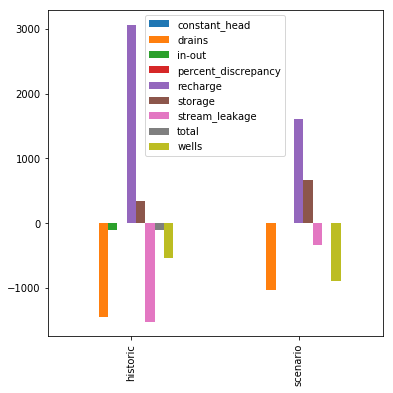

In [24]:
lst = flopy.utils.MfListBudget(os.path.join(m_d,"freyberg.list"))
df = lst.get_dataframes(diff=True)[0]
ax = df.plot(kind="bar",figsize=(6,6))
a = ax.set_xticklabels(["historic","scenario"],rotation=90)

### see how our existing observation ensemble compares to the truth

sw-gw outputs:

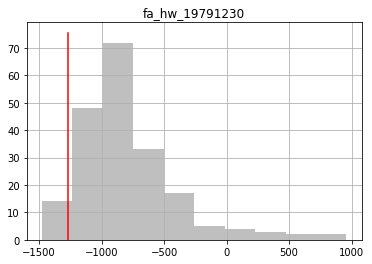

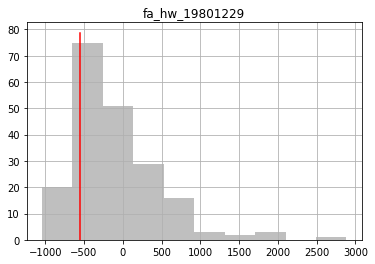

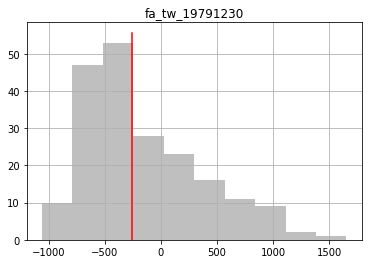

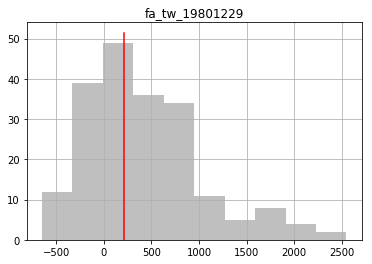

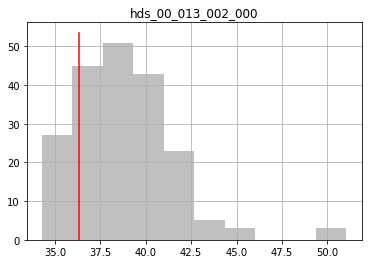

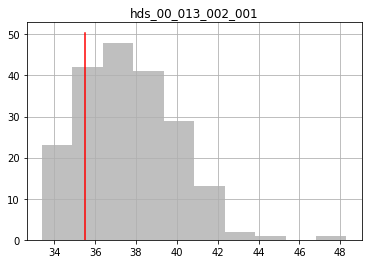

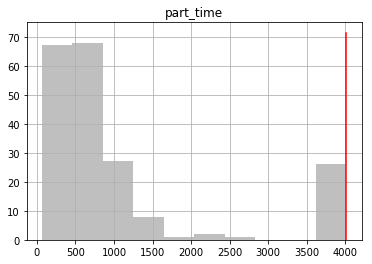

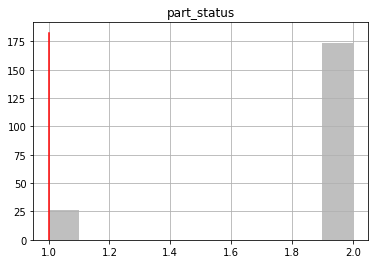

In [25]:
obs = pst.observation_data

for forecast in fnames:
    ax = plt.subplot(111)
    obs_df.loc[:,forecast].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(forecast)
    plt.show()

observations:

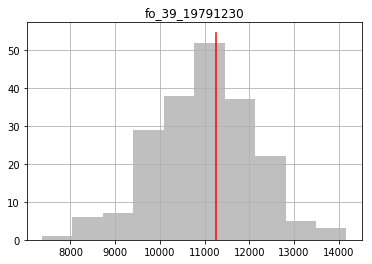

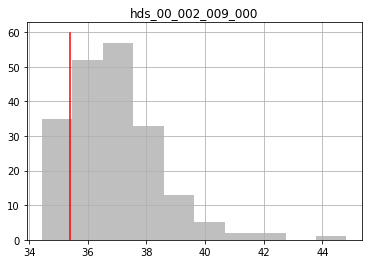

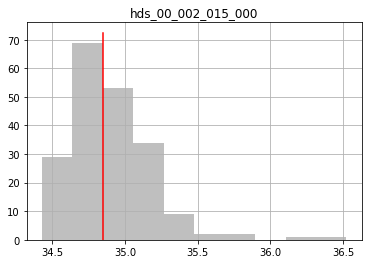

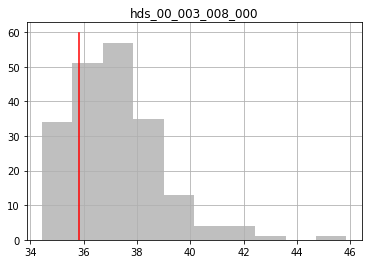

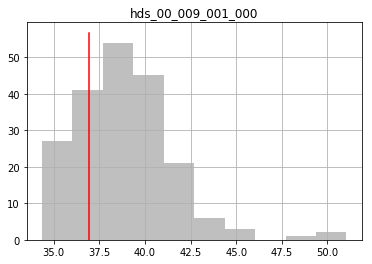

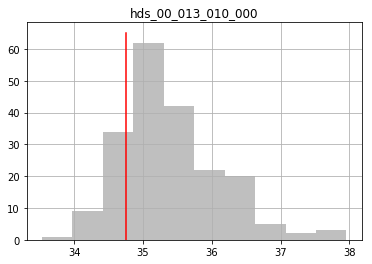

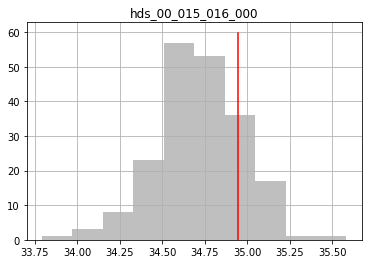

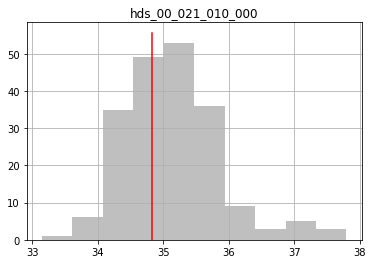

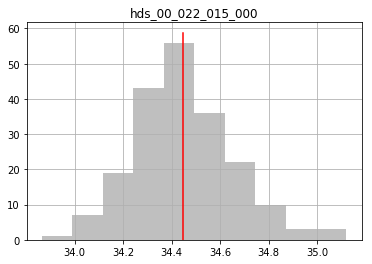

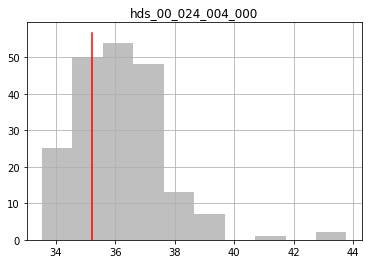

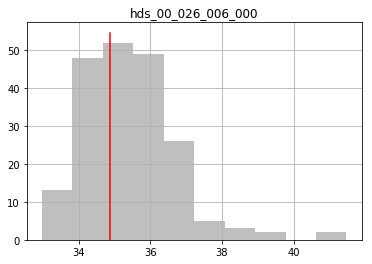

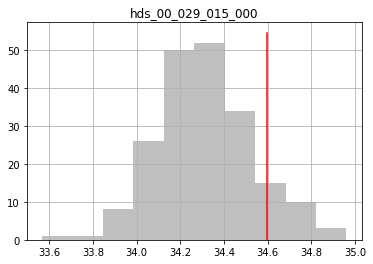

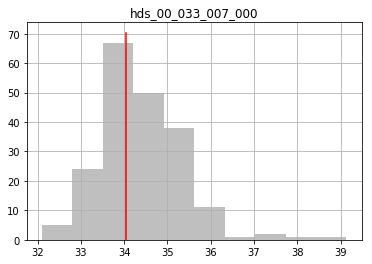

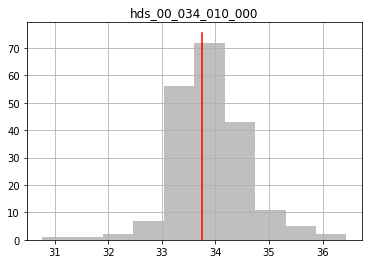

In [26]:
for oname in pst.nnz_obs_names:
    ax = plt.subplot(111)
    obs_df.loc[:,oname].hist(ax=ax,color="0.5",alpha=0.5)
    ax.plot([obs.loc[oname,"obsval"],obs.loc[oname,"obsval"]],ax.get_ylim(),"r")
    ax.set_title(oname)
    plt.show()